<a href="https://colab.research.google.com/github/ashasch/portfolio_project2/blob/main/project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Запит до бд

In [1]:
from google.colab import auth
from google.cloud import bigquery
import numpy as np
import pandas as pd
from scipy.stats import norm

auth.authenticate_user()

client = bigquery.Client(project="data-analytics-mate")

query = """
SELECT
    s.date AS order_date,
    o.ga_session_id,
    sp.continent,
    sp.country,
    sp.device,
    sp.browser,
    sp.mobile_model_name,
    sp.operating_system,
    sp.language,
    sp.medium AS traffic_source,
    sp.channel AS traffic_channel,
    ac.id AS registered_user_id,
    CASE WHEN ac.is_verified = 1 THEN 'Yes' ELSE 'No' END AS is_email_verified,
    CASE WHEN ac.is_unsubscribed = 1 THEN 'No' ELSE 'Yes' END AS is_subscribed,
    p.category AS product_category,
    p.name AS product_name,
    p.price AS product_price,
    p.short_description AS product_description
FROM
    `DA.order` o
LEFT JOIN
    `DA.session` s ON o.ga_session_id = s.ga_session_id
LEFT JOIN
    `DA.session_params` sp ON o.ga_session_id = sp.ga_session_id
LEFT JOIN
    `DA.account_session` acs ON o.ga_session_id = acs.ga_session_id
LEFT JOIN
    `DA.account` ac ON acs.account_id = ac.id
LEFT JOIN
    `DA.product` p ON o.item_id = p.item_id
"""


query_job = client.query(query)
results = query_job.result()

df = results.to_dataframe()
df.head()

,order_date,ga_session_id,continent,country,device,browser,mobile_model_name,operating_system,language,traffic_source,traffic_channel,registered_user_id,is_email_verified,is_subscribed,product_category,product_name,product_price,product_description
0,2020-11-06,7799937037,Europe,Slovakia,mobile,Chrome,<Other>,Web,fr,referral,Paid Search,<NA>,No,Yes,Children's furniture,TROFAST,5.0,"Lid, 20x28 cm"
1,2020-11-10,4020421879,Americas,United States,desktop,Chrome,Safari,Macintosh,en,(none),Direct,653378,Yes,Yes,Children's furniture,TROFAST,5.0,"Lid, 20x28 cm"
2,2020-11-24,6717382496,Americas,United States,desktop,Chrome,Chrome,Web,en-us,referral,Social Search,<NA>,No,Yes,Children's furniture,TROFAST,5.0,"Lid, 20x28 cm"
3,2020-11-26,2093497337,Americas,United States,desktop,Chrome,Chrome,Web,en-us,(none),Direct,<NA>,No,Yes,Children's furniture,TROFAST,5.0,"Lid, 20x28 cm"
4,2020-12-03,9506718330,Europe,Spain,desktop,Chrome,ChromeBook,<Other>,en-us,referral,Paid Search,<NA>,No,Yes,Children's furniture,TROFAST,5.0,"Lid, 20x28 cm"


# Метрики та аналіз

In [2]:
# Загальна кількість колонок
total_columns = df.shape[1]

# Кількість колонок числового типу
numeric_columns = df.select_dtypes(include=['number']).columns.tolist()
numeric_columns_count = len(numeric_columns)

# Кількість колонок категоріального типу
categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_columns_count = len(categorical_columns)

# Кількість колонок типу datetime
datetime_columns = df.select_dtypes(include=['datetime']).columns.tolist()
datetime_columns_count = len(datetime_columns)

# Кількість унікальних сесій
unique_sessions = df['ga_session_id'].nunique()

# Перевірка типу даних колонки 'order_date'
print(df['order_date'].dtype)

# Якщо це не datetime, перетворюємо
if not pd.api.types.is_datetime64_any_dtype(df['order_date']):
    df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')

# Перевірка після перетворення
print(df['order_date'].dtype)

# Знову обчислюємо період часу
time_period_start = df['order_date'].min()
time_period_end = df['order_date'].max()

# Чи є пропущені значення
missing_values = df.isnull().sum()
missing_columns = missing_values[missing_values > 0].index.tolist()

# Колонки з найбільшою кількістю пропущених значень
most_missing_column = missing_values.idxmax()
most_missing_count = missing_values.max()

# Причини пропусків
# Ви можете оцінити пропуски, залежно від домену. Наприклад:
# Пропуски у колонці `registered_user_id` можуть бути через незареєстрованих користувачів.

# Вивід результатів
print(f"Загальна кількість колонок: {total_columns}")
print(f"Кількість числових колонок: {numeric_columns_count}, Числові колонки: {numeric_columns}")
print(f"Кількість категоріальних колонок: {categorical_columns_count}, Категоріальні колонки: {categorical_columns}")
print(f"Кількість колонок типу datetime: {datetime_columns_count}, Datetime колонки: {datetime_columns}")
print(f"Кількість унікальних сесій: {unique_sessions}")
print(f"Період часу: від {time_period_start} до {time_period_end}")
print(f"Чи є пропущені значення: {'Так' if missing_columns else 'Ні'}")
if missing_columns:
    print(f"Колонки з пропущеними значеннями: {missing_columns}")
    print(f"Колонка з найбільшою кількістю пропусків: {most_missing_column} ({most_missing_count} пропусків)")
    print("Можливі причини пропусків залежно від даних:")
    if 'registered_user_id' in missing_columns:
        print("- Незареєстровані користувачі не мають `registered_user_id`")


dbdate
datetime64[ns]
Загальна кількість колонок: 18
Кількість числових колонок: 3, Числові колонки: ['ga_session_id', 'registered_user_id', 'product_price']
Кількість категоріальних колонок: 14, Категоріальні колонки: ['continent', 'country', 'device', 'browser', 'mobile_model_name', 'operating_system', 'language', 'traffic_source', 'traffic_channel', 'is_email_verified', 'is_subscribed', 'product_category', 'product_name', 'product_description']
Кількість колонок типу datetime: 0, Datetime колонки: []
Кількість унікальних сесій: 33538
Період часу: від 2020-11-01 00:00:00 до 2021-01-27 00:00:00
Чи є пропущені значення: Так
Колонки з пропущеними значеннями: ['language', 'registered_user_id']
Колонка з найбільшою кількістю пропусків: registered_user_id (30757 пропусків)
Можливі причини пропусків залежно від даних:
- Незареєстровані користувачі не мають `registered_user_id`


In [ ]:
# Загальні продажі та кількість замовлень за континентами і країнами
continent_sales = df.groupby('continent')['product_price'].sum().nlargest(3)
country_sales = df.groupby('country')['product_price'].sum().nlargest(5)

continent_orders = df['continent'].value_counts().nlargest(3)
country_orders = df['country'].value_counts().nlargest(5)

print("Топ-3 континенти за продажами:\n", continent_sales, "\n")
print("Топ-5 країн за продажами:\n", country_sales, "\n")
print("Топ-3 континенти за кількістю замовлень:\n", continent_orders, "\n")
print("Топ-5 країн за кількістю замовлень:\n", country_orders)


Топ-3 континенти за продажами:
 continent
Americas    17665280.0
Asia         7601298.3
Europe       5934624.2
Name: product_price, dtype: float64 

Топ-5 країн за продажами:
 country
United States     13943553.9
India              2809762.0
Canada             2437921.0
United Kingdom      938317.9
France              710692.8
Name: product_price, dtype: float64 

Топ-3 континенти за кількістю замовлень:
 continent
Americas    18553
Asia         7950
Europe       6261
Name: count, dtype: int64 

Топ-5 країн за кількістю замовлень:
 country
United States     14673
India              3029
Canada             2560
United Kingdom     1029
France              678
Name: count, dtype: int64


In [ ]:
top_categories = df.groupby('product_category')['product_price'].sum().nlargest(10)
print("Топ-10 категорій за загальною сумою продажів:\n", top_categories)


Топ-10 категорій за загальною сумою продажів:
 product_category
Sofas & armchairs                   8388254.5
Chairs                              6147748.8
Beds                                4919725.0
Bookcases & shelving units          3640818.1
Cabinets & cupboards                2336499.5
Outdoor furniture                   2142222.2
Tables & desks                      1790307.5
Chests of drawers & drawer units     906562.5
Bar furniture                        735503.0
Children's furniture                 467697.0
Name: product_price, dtype: float64


In [ ]:
# Продажі за моделями девайсів
device_sales = df.groupby('mobile_model_name')['product_price'].sum()
device_percentage = (device_sales / device_sales.sum()) * 100
print("Продажі за моделями девайсів (%):\n", device_percentage, "\n")

# Продажі за джерелами трафіку
traffic_sales = df.groupby('traffic_source')['product_price'].sum()
traffic_percentage = (traffic_sales / traffic_sales.sum()) * 100
print("Продажі за джерелами трафіку (%):\n", traffic_percentage)


Продажі за моделями девайсів (%):
 mobile_model_name
<Other>       20.440966
Chrome        27.835602
ChromeBook     5.725241
Edge           2.180746
Firefox        1.316998
Pixel 3        0.341390
Pixel 4 XL     0.369976
Safari        20.302504
iPad           1.403910
iPhone        20.082667
Name: product_price, dtype: float64 

Продажі за джерелами трафіку (%):
 traffic_source
(data deleted)     6.386645
(none)            23.442345
<Other>           14.047882
cpc                4.273902
organic           34.202840
referral          17.646386
Name: product_price, dtype: float64


In [ ]:
# Підтверджені email
confirmed_emails = df['is_email_verified'].value_counts(normalize=True) * 100
print("Відсоток підтверджених email:\n", confirmed_emails, "\n")

# Відписані користувачі
subscribed_users = df['is_subscribed'].value_counts(normalize=True) * 100
print("Відсоток підписаних користувачів:\n", subscribed_users)


Відсоток підтверджених email:
 is_email_verified
No     94.069414
Yes     5.930586
Name: proportion, dtype: float64 

Відсоток підписаних користувачів:
 is_subscribed
Yes    98.667183
No      1.332817
Name: proportion, dtype: float64


# Аналіз динаміки продажів

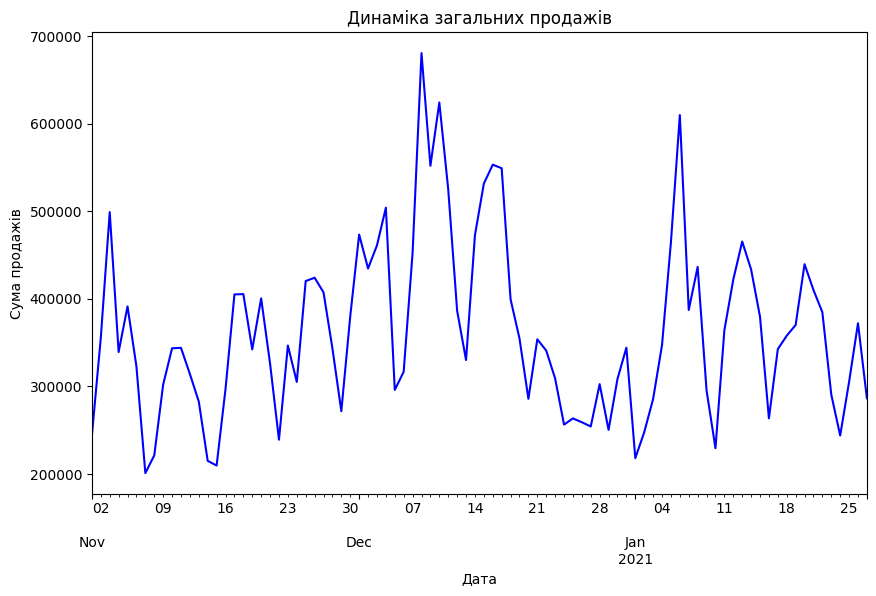

In [ ]:
sales_by_date = df.groupby('order_date')['product_price'].sum()

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sales_by_date.plot(title="Динаміка загальних продажів", color="blue")
plt.xlabel("Дата")
plt.ylabel("Сума продажів")
plt.show()


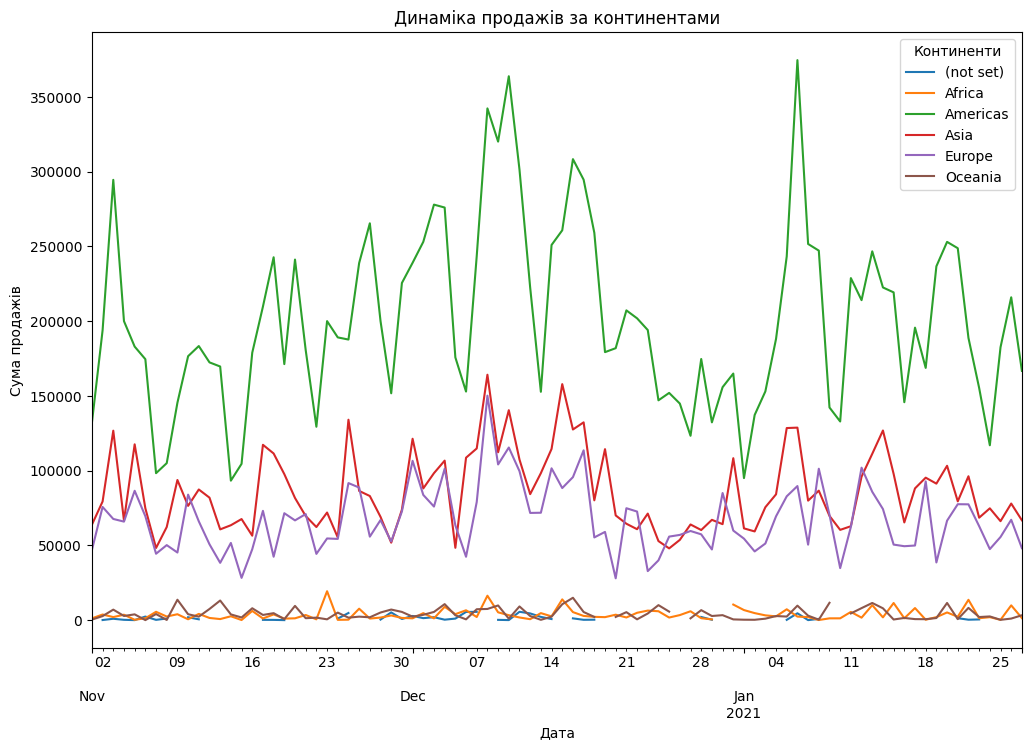

In [ ]:
continent_sales_by_date = df.groupby(['order_date', 'continent'])['product_price'].sum().unstack()

continent_sales_by_date.plot(title="Динаміка продажів за континентами", figsize=(12, 8))
plt.xlabel("Дата")
plt.ylabel("Сума продажів")
plt.legend(title="Континенти")
plt.show()


Топ-10 днів з найбільшою волатильністю:
order_date
2020-12-08    228086.2
2021-01-07    222600.1
2020-12-05    208043.7
2020-11-04    159792.5
2020-12-18    149756.7
2021-01-06    145219.1
2020-11-03    143472.8
2020-12-14    142610.4
2021-01-09    141031.6
2020-12-12    138635.1
Name: product_price, dtype: float64


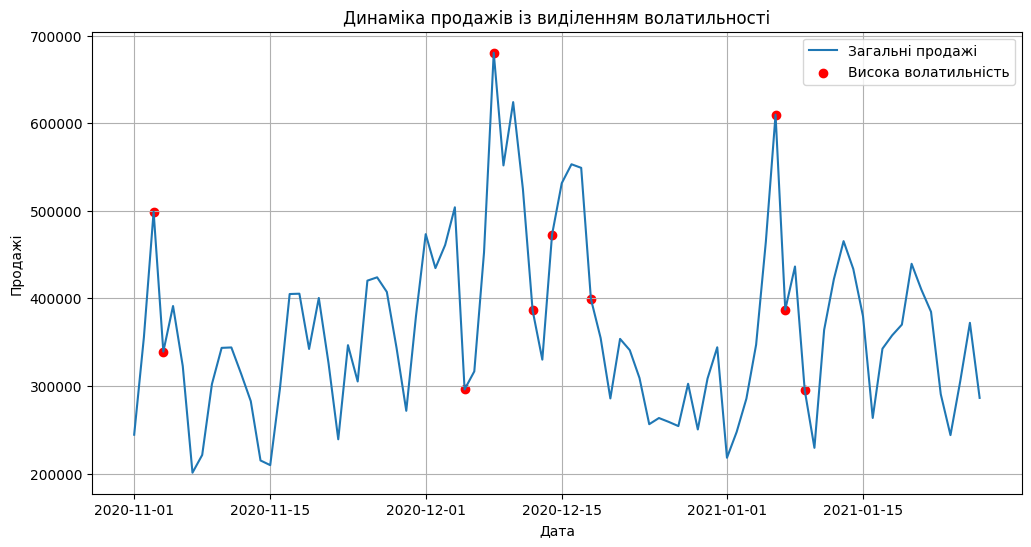

In [ ]:
#Знайти періоди з найбільшою волатильністю продажів (найбільші зміни між днями). Побудувати графік, який демонструє зміну волатильності.
# Групуємо дані за датою і знаходимо загальні продажі
daily_sales = df.groupby('order_date')['product_price'].sum().sort_index()

# Обчислюємо зміну продажів (різницю між днями)
sales_volatility = daily_sales.diff().abs()

# Знаходимо дні з найвищою волатильністю
top_volatility_days = sales_volatility.nlargest(10)

print("Топ-10 днів з найбільшою волатильністю:")
print(top_volatility_days)

# Візуалізація
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(daily_sales.index, daily_sales, label="Загальні продажі")
plt.scatter(top_volatility_days.index, daily_sales[top_volatility_days.index], color='red', label="Висока волатильність")
plt.title("Динаміка продажів із виділенням волатильності")
plt.xlabel("Дата")
plt.ylabel("Продажі")
plt.legend()
plt.grid()
plt.show()


# Зведені таблиці

In [ ]:
session_pivot = pd.pivot_table(
    df,
    values='ga_session_id',
    index='traffic_channel',
    columns='device',
    aggfunc='count'
)
print("Кількість сесій за каналами трафіку та типами девайсів:\n", session_pivot)

Кількість сесій за каналами трафіку та типами девайсів:
 device           desktop  mobile  tablet
traffic_channel                         
Direct              4655    2985     160
Organic Search      7011    4655     255
Paid Search         5261    3574     207
Social Search       1594    1065      57
Undefined           1181     834      44


In [ ]:
df.columns = df.columns.str.strip()
country_data = df.get('country')
if country_data is None:
    print("Стовпець 'country' не знайдено!")
else:
    print(country_data.head())


top_countries = country_sales.index.tolist()
top_categories_pivot = df[df['country'].isin(top_countries)].pivot_table(
    values='product_price',
    index='product_category',
    columns='country',
    aggfunc='sum'
)
print("Загальні продажі за категоріями товарів у топ-5 країнах:\n", top_categories_pivot)


0         Slovakia
1    United States
2    United States
3    United States
4            Spain
Name: country, dtype: object
Загальні продажі за категоріями товарів у топ-5 країнах:
 country                                 Canada    France     India  \
product_category                                                     
Bar furniture                          51724.0   11199.0   57657.0   
Beds                                  354772.0  116414.0  358319.5   
Bookcases & shelving units            278981.9   73830.0  364507.4   
Cabinets & cupboards                  181802.0   59101.5  191888.0   
Café furniture                         13368.0    2299.0   13738.0   
Chairs                                417740.8  134029.4  544309.2   
Chests of drawers & drawer units       71952.0   21544.5   73111.0   
Children's furniture                   30264.0   14258.0   39177.0   
Nursery furniture                      11090.0    4968.0   11516.0   
Outdoor furniture                     185322.8  

Середній чек для кожного типу пристрою та каналу трафіку:
traffic_channel      Direct  Organic Search  Paid Search  Social Search  \
device                                                                    
desktop          960.818346      969.064014   946.013648     908.020577   
mobile           963.255578      947.126767   931.738276     945.265070   
tablet           918.725625      902.622353   985.695652    1368.659649   

traffic_channel    Undefined  
device                        
desktop           993.191533  
mobile            915.219305  
tablet           1460.202273  


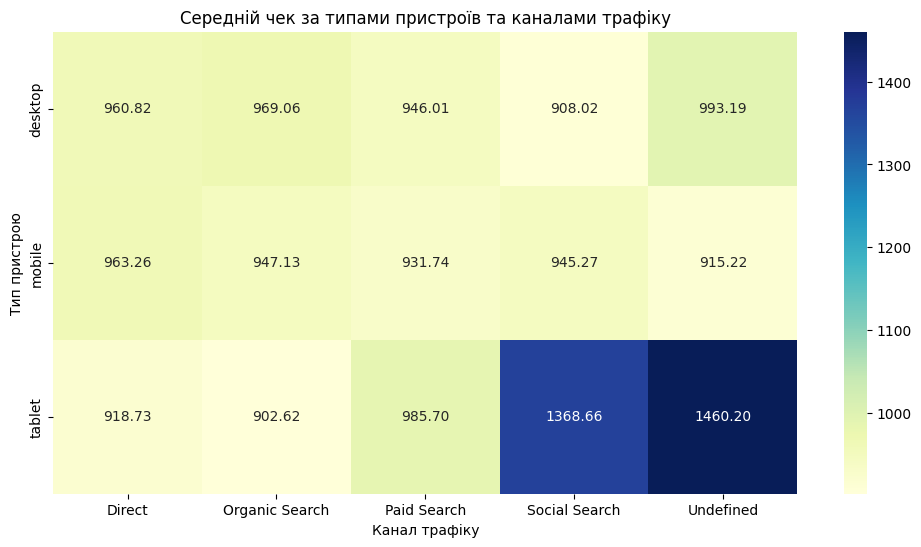

In [ ]:
#Створити зведену таблицю, яка показує середній чек (середню суму покупки) для кожного типу пристрою і кожного каналу трафіку.
pivot_avg_order = df.pivot_table(
    index='device',
    columns='traffic_channel',
    values='product_price',
    aggfunc='mean'
)

print("Середній чек для кожного типу пристрою та каналу трафіку:")
print(pivot_avg_order)

# Візуалізація теплової карти
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_avg_order, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Середній чек за типами пристроїв та каналами трафіку")
plt.xlabel("Канал трафіку")
plt.ylabel("Тип пристрою")
plt.show()


Загальні продажі для кожного континенту та каналу трафіку:
traffic_channel     Direct  Organic Search  Paid Search  Social Search  \
continent                                                                
(not set)          21443.0         15080.0      19931.0        11224.4   
Africa             70028.0        129908.4      88195.0        31187.6   
Americas         4222962.0       6294563.2    4627454.3      1384427.7   
Asia             1755294.5       2725953.8    2039256.5       576031.8   
Europe           1343093.9       2154138.6    1620206.1       498507.1   
Oceania            82102.0        113507.6     116006.5        30727.1   

traffic_channel  Undefined  
continent                   
(not set)           6389.0  
Africa             11912.0  
Americas         1135872.8  
Asia              504761.7  
Europe            318678.5  
Oceania            22887.0  


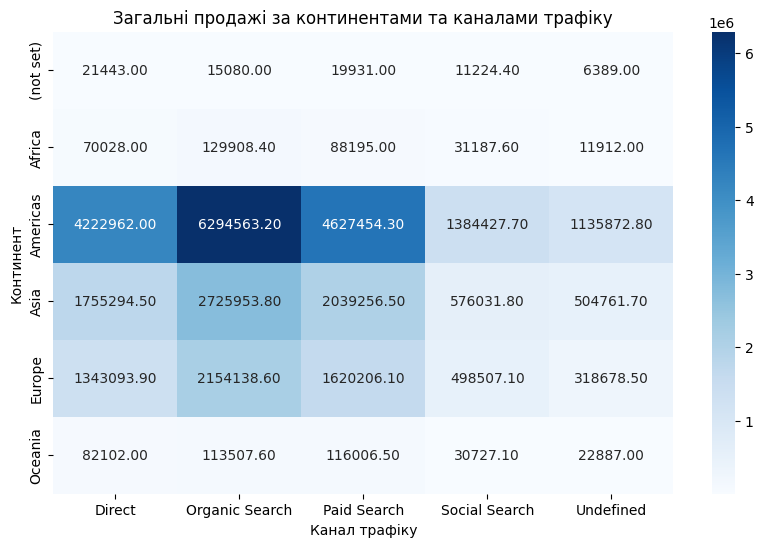

In [ ]:
pivot_sales = df.pivot_table(
    index='continent',
    columns='traffic_channel',
    values='product_price',
    aggfunc='sum'
)

print("Загальні продажі для кожного континенту та каналу трафіку:")
print(pivot_sales)

# Візуалізація
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_sales, annot=True, fmt=".2f", cmap="Blues")
plt.title("Загальні продажі за континентами та каналами трафіку")
plt.xlabel("Канал трафіку")
plt.ylabel("Континент")
plt.show()


# Статистичний аналіз взаємозв’язків

In [ ]:
sessions_and_sales = df.groupby('order_date').agg({'ga_session_id': 'count', 'product_price': 'sum'})

# Кореляція
correlation = sessions_and_sales.corr().iloc[0, 1]
print("Коефіцієнт кореляції між сесіями та продажами:", correlation)


Коефіцієнт кореляції між сесіями та продажами: 0.964242253312488


In [ ]:
from scipy.stats import pearsonr

corr, p_value = pearsonr(sessions_and_sales['ga_session_id'], sessions_and_sales['product_price'])
print(f"Кореляція: {corr}, p-value: {p_value}")


Кореляція: 0.9642422533124871, p-value: 2.2447783149167257e-51


In [ ]:
# Перевіримо, чи існує кореляція між кількістю сесій (ga_session_id) і середньою ціною продуктів у кожній країні.
# Групуємо дані за країною
country_stats = df.groupby('country').agg(
    total_sessions=('ga_session_id', 'count'),
    avg_price=('product_price', 'mean')
).dropna()

# Обчислюємо кореляцію
from scipy.stats import pearsonr

correlation, p_value = pearsonr(country_stats['total_sessions'], country_stats['avg_price'])

print(f"Коефіцієнт кореляції: {correlation:.2f}, p-значення: {p_value:.4f}")
if p_value < 0.05:
    print("Існує статистично значущий взаємозв'язок між кількістю сесій і середньою ціною продуктів.")
else:
    print("Взаємозв'язок між кількістю сесій і середньою ціною продуктів не є статистично значущим.")


Коефіцієнт кореляції: 0.02, p-значення: 0.8127
Взаємозв'язок між кількістю сесій і середньою ціною продуктів не є статистично значущим.


In [ ]:
# Перевіримо, чи є різниця в середніх продажах між користувачами, які підписані на розсилку, і тими, хто відписався.
# Розділяємо вибірки
subscribed_sales = df[df['is_subscribed'] == 1]['product_price']
unsubscribed_sales = df[df['is_subscribed'] == 0]['product_price']

# Виконуємо t-тест
t_stat, p_value = ttest_ind(subscribed_sales, unsubscribed_sales, nan_policy='omit')

print(f"t-статистика: {t_stat:.2f}, p-значення: {p_value:.4f}")
if p_value < 0.05:
    print("Є статистично значуща різниця в середніх продажах між підписаними та відписаними користувачами.")
else:
    print("Різниця в середніх продажах між підписаними та відписаними користувачами не є статистично значущою.")


t-статистика: nan, p-значення: nan
Різниця в середніх продажах між підписаними та відписаними користувачами не є статистично значущою.


# Аналіз відмінностей між групами

In [ ]:
registered_sales = df[df['registered_user_id'].notnull()].groupby('order_date')['product_price'].sum()
unregistered_sales = df[df['registered_user_id'].isnull()].groupby('order_date')['product_price'].sum()

from scipy.stats import ttest_ind

t_stat, p_val = ttest_ind(registered_sales, unregistered_sales, nan_policy='omit')
print(f"T-статистика: {t_stat}, p-value: {p_val}")


T-статистика: -30.552203134528643, p-value: 7.757552970935199e-72


In [ ]:
# Порівняння середніх цін товарів у двох категоріях
# Вибірки для двох категорій
category_a_sales = df[df['product_category'] == 'Category A']['product_price']
category_b_sales = df[df['product_category'] == 'Category B']['product_price']

# Виконуємо t-тест
t_stat, p_value = ttest_ind(category_a_sales, category_b_sales, nan_policy='omit')

print(f"t-статистика: {t_stat:.2f}, p-значення: {p_value:.4f}")
if p_value < 0.05:
    print("Середні ціни товарів значно відрізняються між категоріями A і B.")
else:
    print("Середні ціни товарів не мають статистично значущої різниці між категоріями A і B.")


t-статистика: nan, p-значення: nan
Середні ціни товарів не мають статистично значущої різниці між категоріями A і B.


In [ ]:
from statsmodels.stats.proportion import proportions_ztest

# Фільтруємо дані для Європи та Америки
europe_data = df[df['continent'] == 'Europe']
america_data = df[df['continent'] == 'America']

# Кількість сесій з органічним трафіком
europe_organic_sessions = europe_data[europe_data['traffic_channel'] == 'Organic']['ga_session_id'].count()
america_organic_sessions = america_data[america_data['traffic_channel'] == 'Organic']['ga_session_id'].count()

# Загальна кількість сесій
europe_total_sessions = europe_data['ga_session_id'].count()
america_total_sessions = america_data['ga_session_id'].count()

# Вхідні дані для z-тесту
counts = [europe_organic_sessions, america_organic_sessions]
totals = [europe_total_sessions, america_total_sessions]

# Виконуємо z-тест для пропорцій
z_stat, p_value = proportions_ztest(counts, totals)

print(f"z-статистика: {z_stat:.2f}, p-значення: {p_value:.4f}")
if p_value < 0.05:
    print("Доля сесій з органічним трафіком значно відрізняється між Європою та Америкою.")
else:
    print("Доля сесій з органічним трафіком не має статистично значущої різниці між Європою та Америкою.")


z-статистика: nan, p-значення: nan
Доля сесій з органічним трафіком не має статистично значущої різниці між Європою та Америкою.


/usr/local/lib/python3.10/dist-packages/statsmodels/stats/proportion.py:1004: RuntimeWarning: invalid value encountered in divide
  prop = count * 1. / nobs
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/proportion.py:1020: RuntimeWarning: divide by zero encountered in divide
  nobs_fact = np.sum(1. / nobs)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/proportion.py:1023: RuntimeWarning: invalid value encountered in scalar multiply
  var_ = p_pooled * (1 - p_pooled) * nobs_fact
